In [1]:
import torch
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn as sk
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, VECM
import statsmodels.tsa.vector_ar.vecm as vecm 
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.vector_ar.util as var_tool
from pandarallel import pandarallel
from multiprocessing import Pool
import tqdm
import pickle
import itertools
from collections import defaultdict, OrderedDict
import os
import datetime
import copy
# from datetime import datetime
# from datetime import date

from help_function import *

%load_ext rpy2.ipython

pandarallel.initialize(progress_bar=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [5]:
data_path = f'data/mempool'
data_name = 'aave'
data_name = 'chainlink'

In [6]:
def get_time_df(data_name):
    event_df = pd.read_csv(os.path.join(data_path, f'{data_name}_mempool.csv'))
    spy_df = pd.read_csv(os.path.join(data_path, 'spy_node' ,f'{data_name}.csv'))
    time_df = pd.merge(event_df, spy_df[['received_at', 'code', 'tx_hash']], left_on='txHash', right_on='tx_hash').iloc[:,:-1]
    time_df['blockTime'] = time_df['blockTime'].apply(lambda x: datetime.datetime.fromtimestamp(float(x), datetime.timezone.utc))
    time_df['received_at'] = time_df['received_at'].apply(lambda x: datetime.datetime.fromisoformat(x))
    time_df['time_diff_second'] = time_df.apply(lambda df: (df['blockTime'] - df['received_at']).total_seconds(), axis=1)
    return time_df

# Maker

15.42635294871796


(      time_diff_second
 code                  
 2            16.723861
 8            15.240391,
       time_diff_second
 code                  
 2                   44
 8                  307)

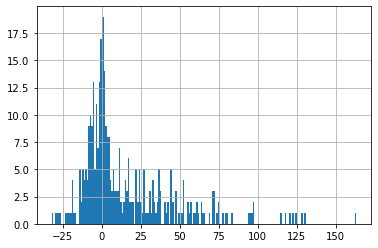

In [36]:
time_df = get_time_df('maker')
time_df = time_df.loc[time_df.groupby('txHash').received_at.idxmin()].reset_index(drop=True)
time_df = time_df[time_df['time_diff_second'] >= -300]
# time_df = time_df[time_df['time_diff_second'] >= 0]

time_df['time_diff_second'].iloc[1:].hist(bins=200)
print(time_df.loc[:,'time_diff_second'].agg('mean'))
time_small_df = time_df[['blockNum', 'blockTime', 'received_at', 'time_diff_second', 'code']]
time_small_df[['time_diff_second', 'code']].groupby('code').agg('mean'), time_small_df[['time_diff_second', 'code']].groupby('code').agg('count')

In [37]:
# blcokFrom := big.NewInt(14577748)
# 	blockTo := big.NewInt(14839909)
# 	blockMax := uint64(14839909)
# 	blockGap := int64(118602)

from_block = 14577748
end_at = 14839909

In [40]:
# from_block = 12466826
# end_at = 14957468

from_block = 14577748
end_at = 14839909
data_list = []
while True:
    if from_block >= end_at: break
    to_block = from_block + 118602
    file_name = f"data/crawled/maker_dao_eth_usd_median_gas_info_{from_block}_{to_block}.csv" 
    data_list.append(pd.read_csv(file_name))
    from_block = to_block
maker_gas_info = pd.concat(data_list)
# maker_gas_info.columns = 'topic0 collateralAsset debtAsset user data blockNum index'.split(' ')
del maker_gas_info['blockNum']
del maker_gas_info['index']

In [41]:
maker_gas_info

,txHash,gas,gasPrice,gasTipCap,gasFeeCap,blockAvgGasTip
0,0x332fbfadc446ea1a7b86b771fab4a33817f317ce1559...,200000,120585238486,1000000000,120585238486,3486540213
1,0x2739880f0226623f18585b92644df71be1f3a078aa73...,200000,123397858560,1472000000,123397858560,12978622697
2,0x6592380003eddd83bee3d1859a53bc50fd8078be96a8...,200000,64651763018,1000000000,64651763018,16724993926
3,0x70d0482da0dc5fd6062e0c16cfd07843a3e13712fb3b...,200000,65285080404,1000000000,65285080404,2662154416
4,0xa5b9dde843fa3d38151dd0ed64dbe59aadca750a2c97...,200000,79046647736,1000000000,79046647736,7373631736
...,...,...,...,...,...,...
145,0x2c810e102b8296f04dc42cf24e0cdb009389ece6492a...,200000,136318955190,1000000000,136318955190,8418211838
146,0xcf6130ab07e00b1ae98993c1816f54f74dcdf2cb0c16...,200000,119035186978,1000000000,119035186978,29571710022
147,0x535bc25e89b71090e26ff7f7c54106423e4acc562c52...,200000,95195335080,1000000000,95195335080,15123528870
148,0xf405d5fdec96d08c19be218c6282088f1d2db79ba4b8...,200000,103597843830,1000000000,103597843830,15073496569


In [42]:
maker_df = time_df.merge(maker_gas_info, how='left', left_on='txHash', right_on='txHash')
del maker_df['received_at']
del maker_df['blockTime']
# del chainlink_df['txHash']
maker_df['gasPrice'] = maker_df['gasPrice'] * 1e-9
maker_df['gasTipCap'] = maker_df['gasTipCap'] * 1e-9
maker_df['gasFeeCap'] = maker_df['gasFeeCap'] * 1e-9
maker_df['blockAvgGasTip'] = maker_df['blockAvgGasTip'] * 1e-9
maker_col = maker_df.columns
maker_df

,blockNum,index,txHash,price,code,time_diff_second,gas,gasPrice,gasTipCap,gasFeeCap,blockAvgGasTip
0,14730859,216,0x00bc803dd4841b7bdb4990fd950e6144e553d29fec8d...,2691.110000,8,4.394687,200000,116.671705,1.000000,116.671705,14.264896
1,14741761,254,0x00dbc558f92a0a27ae3181fd1f00aa774ffc22e3c259...,2446.110000,8,-0.216767,200000,44.393231,1.000000,44.393231,4.663916
2,14640489,12,0x0272328ea351fcd777b3b92b72d7fcce54549a6e5796...,2957.939613,8,0.566113,200000,58.312995,1.000000,58.312995,3.300816
3,14649174,249,0x028779186017a5580fbeb456e37d1536676ce89fcefa...,2949.080000,8,-2.040808,200000,85.862566,1.000000,85.862566,31.669594
4,14759717,144,0x02f2c4158a32d3814276717667d1ccc1f339ab781fa0...,1783.620000,2,-2.384322,200000,966.723120,1.500000,966.723120,25.077854
...,...,...,...,...,...,...,...,...,...,...,...
346,14759227,288,0xfd944e6799e23bf8f6e8d079c60da7ac148e2df9b347...,1820.810000,8,-8.200686,200000,1085.302414,1.940000,1085.302414,57.364495
347,14707986,470,0xfe3bccb857f1e9bef11688c39b0251be385ceac48a6c...,2794.024287,2,14.914837,200000,71.645577,1.000000,71.645577,11.652712
348,14605753,363,0xfe60362f02ab7582e504965739ec5e6406e60c5fd552...,3011.955415,8,37.245298,200000,52.899788,1.000000,52.899788,3.319182
349,14586309,60,0xfeaa1104aec8abe39a189bafbb0afc0bdaf97fcdd33a...,3017.800000,8,2.735629,200000,63.150583,1.097096,63.150583,6.496985


# Chainlink 

-5.328044999999997


(      time_diff_second
 code                  
 2            -8.544998
 7            -7.452662
 8            -5.027843,
       time_diff_second
 code                  
 2                  208
 7                    1
 8                 2236)

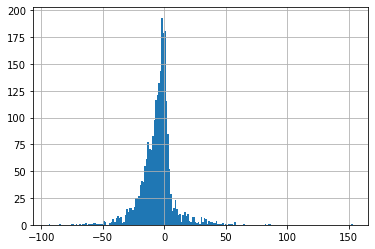

In [43]:
time_df = get_time_df('chainlink')

time_df = time_df.loc[time_df.groupby('txHash').received_at.idxmin()].reset_index(drop=True)
time_df = time_df[time_df['time_diff_second'] >= -300]
# time_df = time_df[time_df['time_diff_second'] >= 0]

time_df['time_diff_second'].iloc[1:].hist(bins=200)
print(time_df.loc[:,'time_diff_second'].agg('mean'))
time_small_df = time_df[['blockNum', 'blockTime', 'received_at', 'time_diff_second', 'code']]
time_small_df[['time_diff_second', 'code']].groupby('code').agg('mean'), time_small_df[['time_diff_second', 'code']].groupby('code').agg('count')

In [33]:
time_df['blockNum'].max()

14839908

In [35]:
data_list

[]

In [44]:
# from_block = 12466826
# end_at = 14957468

from_block = 14577748
end_at = 14839909
data_list = []
while True:
    if from_block >= end_at: break
    to_block = from_block + 118602
    file_name = f"data/crawled/chainlink_eth_usd_gas_info_{from_block}_{to_block}.csv" 
    data_list.append(pd.read_csv(file_name))
    from_block = to_block
chainlink_gas_info = pd.concat(data_list)
# maker_gas_info.columns = 'topic0 collateralAsset debtAsset user data blockNum index'.split(' ')
del chainlink_gas_info['blockNum']
del chainlink_gas_info['index']

In [45]:
chainlink_gas_info

,txHash,gas,gasPrice,gasTipCap,gasFeeCap,blockAvgGasTip
0,0x9a0294882c114ab89fe6d8e34307ed4f1b6a54fe2b89...,500000,102434295097,102434295097,102434295097,13102984776
1,0x5a2a0ba17e4a0f5045595a93d2f71dbe22306135548c...,500000,88553726943,88553726943,88553726943,30834359008
2,0x2ba5f37814564d2bc5416d7cc69d9725db6cc9794c96...,500000,47667239923,47667239923,47667239923,24319948745
3,0x319efc93ff3c980358b8401a91dd52b651448b4fdd3e...,400000,81473028723,2000000000,81473028723,20664468204
4,0x36a8953dc1b5b051498c16ed6e4802e67dc79804b1f4...,500000,51588794384,51588794384,51588794384,30300741944
...,...,...,...,...,...,...
1052,0x3543e5bbb151c2c9a06a2e0b3af5c9876b88c8897882...,500000,116771001056,2000000000,116771001056,5727338070
1053,0x8939b7e0d7002126e59334936ccbf9b4b26026d793fc...,500000,76566009959,2000000000,76566009959,16339408825
1054,0x505b0cc870fdb909ea25a733139164c8b51c9462f823...,500000,43185242683,43185242683,43185242683,18133927855
1055,0x28036c52ead98d8dbf47c60154fe64cebe94cb567aff...,500000,123117003160,2500000000,123117003160,23439894672


In [46]:
chainlink_df = time_df.merge(chainlink_gas_info, how='left', left_on='txHash', right_on='txHash')
chainlink_df['price'] = chainlink_df['current']
del chainlink_df['current']
del chainlink_df['received_at']
del chainlink_df['blockTime']
# del chainlink_df['txHash']
chainlink_df['gasPrice'] = chainlink_df['gasPrice'] * 1e-9
chainlink_df['gasTipCap'] = chainlink_df['gasTipCap'] * 1e-9
chainlink_df['gasFeeCap'] = chainlink_df['gasFeeCap'] * 1e-9
chainlink_df['blockAvgGasTip'] = chainlink_df['blockAvgGasTip'] * 1e-9
chainlink_col = chainlink_df.columns
chainlink_df

,blockNum,index,txHash,code,time_diff_second,gas,gasPrice,gasTipCap,gasFeeCap,blockAvgGasTip,price
0,14652580,38,0x000d903d6b656d533dbf1f6cb489394a0df56e529596...,8,1.167163,500000,63.795698,2.000000,63.795698,10.412016,2814.635517
1,14805304,112,0x0029932c71aadf41a759edfbb35b7bac9039762bc660...,8,-1.312391,500000,71.651197,71.651197,71.651197,14.192116,1956.994856
2,14682536,65,0x002b186b69f1f18c92338d0a671b83b12cb263e78034...,8,-13.267198,500000,30.674344,30.674344,30.674344,9.968492,2821.840000
3,14765124,368,0x00593ce110d05c856b345ecf3f8f9e4c3e74e5121c9c...,8,38.525627,500000,203.698080,2.000000,203.698080,58.172966,2100.360000
4,14814446,552,0x00830d0bd70d733cb611fabcdb22d1b5262baafa7675...,2,-94.113371,500000,110.474542,2.579997,110.474542,100.986685,1950.435000
...,...,...,...,...,...,...,...,...,...,...,...
2440,14778759,43,0xff67aa5bfe2ccc918c63c0341ae7b5812f2c6ed66cc2...,8,-0.028386,500000,21.763873,1.891131,21.763873,4.428223,2037.290000
2441,14679036,139,0xff7f3c1dad6238e7e02af21a91609ca0a2688c622414...,8,-20.964625,500000,114.847875,2.000000,114.847875,9.278035,2843.368800
2442,14651562,102,0xff91bd505d8c3f25037e7db5ee321ce08a3d9d486ba7...,8,2.391693,500000,53.998849,53.998849,53.998849,24.446161,2876.044637
2443,14832190,241,0xff9a4b6f1cf8ad113adbc9669c125f248837678dd574...,8,-11.456767,500000,56.194137,2.000000,56.194137,6.093191,1964.178380


In [47]:
print(chainlink_df['txHash'].iloc[-2])
chainlink_df.iloc[-2]

0xff9a4b6f1cf8ad113adbc9669c125f248837678dd5747124b8b9de6dac3e230d


blockNum                                                     14832190
index                                                             241
txHash              0xff9a4b6f1cf8ad113adbc9669c125f248837678dd574...
code                                                                8
time_diff_second                                           -11.456767
gas                                                            500000
gasPrice                                                    56.194137
gasTipCap                                                         2.0
gasFeeCap                                                   56.194137
blockAvgGasTip                                               6.093191
price                                                      1964.17838
Name: 2443, dtype: object

In [48]:
chainlink_df['chainlink'] = 1
maker_df['chainlink'] = 0
join_df = pd.concat([chainlink_df, maker_df])
join_col = join_df.columns
join_df

,blockNum,index,txHash,code,time_diff_second,gas,gasPrice,gasTipCap,gasFeeCap,blockAvgGasTip,price,chainlink
0,14652580,38,0x000d903d6b656d533dbf1f6cb489394a0df56e529596...,8,1.167163,500000,63.795698,2.000000,63.795698,10.412016,2814.635517,1
1,14805304,112,0x0029932c71aadf41a759edfbb35b7bac9039762bc660...,8,-1.312391,500000,71.651197,71.651197,71.651197,14.192116,1956.994856,1
2,14682536,65,0x002b186b69f1f18c92338d0a671b83b12cb263e78034...,8,-13.267198,500000,30.674344,30.674344,30.674344,9.968492,2821.840000,1
3,14765124,368,0x00593ce110d05c856b345ecf3f8f9e4c3e74e5121c9c...,8,38.525627,500000,203.698080,2.000000,203.698080,58.172966,2100.360000,1
4,14814446,552,0x00830d0bd70d733cb611fabcdb22d1b5262baafa7675...,2,-94.113371,500000,110.474542,2.579997,110.474542,100.986685,1950.435000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
346,14759227,288,0xfd944e6799e23bf8f6e8d079c60da7ac148e2df9b347...,8,-8.200686,200000,1085.302414,1.940000,1085.302414,57.364495,1820.810000,0
347,14707986,470,0xfe3bccb857f1e9bef11688c39b0251be385ceac48a6c...,2,14.914837,200000,71.645577,1.000000,71.645577,11.652712,2794.024287,0
348,14605753,363,0xfe60362f02ab7582e504965739ec5e6406e60c5fd552...,8,37.245298,200000,52.899788,1.000000,52.899788,3.319182,3011.955415,0
349,14586309,60,0xfeaa1104aec8abe39a189bafbb0afc0bdaf97fcdd33a...,8,2.735629,200000,63.150583,1.097096,63.150583,6.496985,3017.800000,0



% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Mon, Aug 29, 2022 - 16:47:45
% Requires LaTeX packages: dcolumn 
\begin{table}[!htbp] \centering 
  \caption{Results} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lD{.}{.}{-3} } 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{1}{c}{\textit{Dependent variable:}} \\ 
\cline{2-2} 
\\[-1.8ex] & \multicolumn{1}{c}{time\_diff\_second} \\ 
\hline \\[-1.8ex] 
 chainlink & -34.407^{***} \\ 
  & (5.844) \\ 
  & \\ 
 I(gasFeeCap - gasTipCap) & 0.006^{***} \\ 
  & (0.002) \\ 
  & \\ 
 blockAvgGasTip & -0.023 \\ 
  & (0.017) \\ 
  & \\ 
 gasTipCap & -13.328^{**} \\ 
  & (5.559) \\ 
  & \\ 
 chainlink:gasTipCap & 13.348^{**} \\ 
  & (5.560) \\ 
  & \\ 
 chainlink:blockAvgGasTip & -0.025 \\ 
  & (0.017) \\ 
  & \\ 
 blockAvgGasTip:gasTipCap & 0.00002^{***} \\ 
  & (0.00000) \\ 
  & \\ 
 Constant & 29.045^{***} \\ 
  & (5.819) \\ 
  & \\ 
\hline \\[-1.8ex] 
Observatio

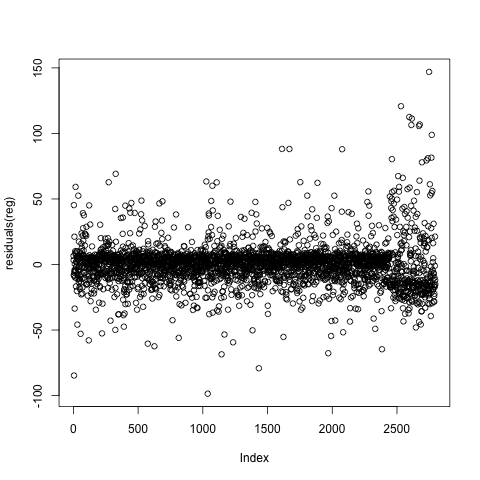

In [67]:
%%R -i join_df,join_col
library(ggplot2); library(car); library(stargazer); library(scales); library(lmtest); library(sandwich)

colnames(join_df) <- unlist(join_col)
rdf <- data.frame(join_df)

# redf['gasBaseCap'] <- redf['gasFeeCap'] - redf['gasTipCap']

reg <- lm(time_diff_second ~ chainlink + I(gasFeeCap-gasTipCap) +  blockAvgGasTip + gasTipCap + gasTipCap:chainlink + blockAvgGasTip:chainlink + blockAvgGasTip:gasTipCap, data=rdf)
plot(residuals(reg))
summary(reg)

stargazer(reg, title="Results", align=TRUE)
summary(reg)


Call:
lm(formula = log(time_diff_second) ~ log(gasTipCap) + chainlink + 
    log(gasTipCap):chainlink, data = rdf)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.1236 -0.9973  0.0918  1.1939  3.9655 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)                2.5973     0.1166  22.269   <2e-16 ***
log(gasTipCap)            -1.4991     0.8875  -1.689   0.0916 .  
chainlink                 -1.5062     0.1363 -11.051   <2e-16 ***
log(gasTipCap):chainlink   1.4962     0.8879   1.685   0.0923 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.624 on 893 degrees of freedom
  (1899 observations deleted due to missingness)
Multiple R-squared:   0.13,	Adjusted R-squared:  0.1271 
F-statistic: 44.49 on 3 and 893 DF,  p-value: < 2.2e-16



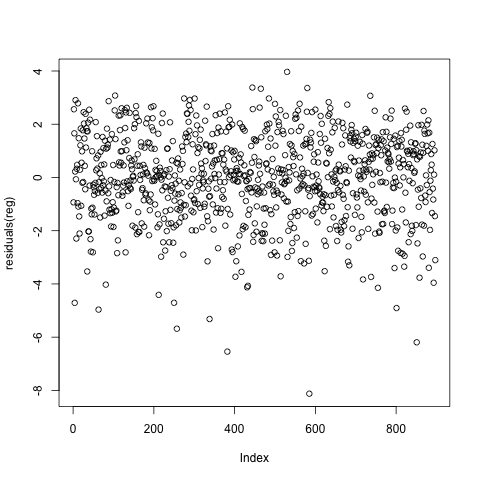

In [20]:
%%R -i join_df,join_col
library(ggplot2); library(car); library(stargazer); library(scales); library(lmtest); library(sandwich)

colnames(join_df) <- unlist(join_col)
rdf <- data.frame(join_df)

reg <- lm(log(time_diff_second) ~ log(gasTipCap) + chainlink + log(gasTipCap):chainlink, data=rdf)
plot(residuals(reg))
summary(reg)


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Mon, Aug 29, 2022 - 05:42:40
% Requires LaTeX packages: dcolumn 
\begin{table}[!htbp] \centering 
  \caption{Results} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lD{.}{.}{-3} } 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{1}{c}{\textit{Dependent variable:}} \\ 
\cline{2-2} 
\\[-1.8ex] & \multicolumn{1}{c}{time\_diff\_second} \\ 
\hline \\[-1.8ex] 
 gas & -0.00000 \\ 
  & (0.00002) \\ 
  & \\ 
 gasTipCap & 0.025^{***} \\ 
  & (0.005) \\ 
  & \\ 
 gasFeeCap & 0.001 \\ 
  & (0.001) \\ 
  & \\ 
 chainlink & -19.939^{***} \\ 
  & (5.674) \\ 
  & \\ 
 Constant & 16.052^{***} \\ 
  & (3.892) \\ 
  & \\ 
\hline \\[-1.8ex] 
Observations & \multicolumn{1}{c}{2,796} \\ 
R$^{2}$ & \multicolumn{1}{c}{0.147} \\ 
Adjusted R$^{2}$ & \multicolumn{1}{c}{0.146} \\ 
Residual Std. Error & \multicolumn{1}{c}{17.251 (df = 2791)} \\ 
F Statistic & \multicolumn{1}{c}{120.4

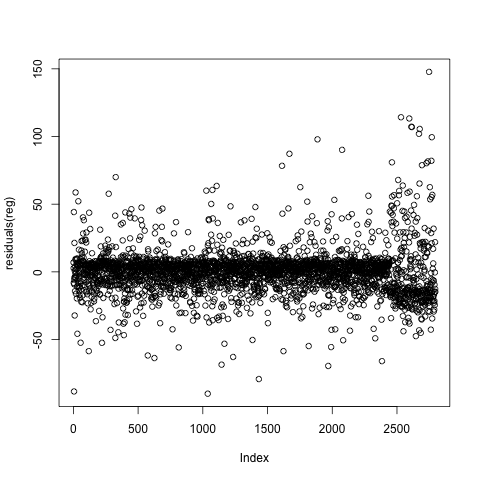

In [13]:
%%R -i join_df,join_col
library(ggplot2); library(car); library(stargazer); library(scales); library(lmtest); library(sandwich)

colnames(join_df) <- unlist(join_col)
rdf <- data.frame(join_df)

reg <- lm(time_diff_second ~ gas + gasTipCap + gasFeeCap + chainlink , data=rdf)
plot(residuals(reg))
summary(reg)


# ttt <- rdf[rdf$chainlink == 0,]
# reg <- lm(time_diff_second ~ gasTipCap +I(gasTipCap**2) + gasFeeCap, data=ttt)
# plot(residuals(reg))
# summary(reg)
reg2 <- lm(gasTipCap ~ chainlink, data=rdf)
summary(reg2)

library(stargazer)
linear.1 <- reg2
linear.2 <- reg
stargazer(linear.2, title="Results", align=TRUE)

# AAVE

-14286.630827511337


(      time_diff_second
 code                  
 2            12.698569
 7           -18.022726
 8        -26099.056973,
       time_diff_second
 code                  
 2                  176
 7                 1380
 8                 1880)

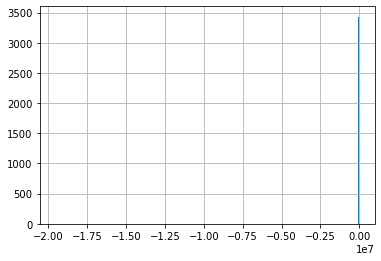

In [12]:
time_df = get_time_df('aave')
time_df = time_df[time_df['time_diff_second'] <= 300]
# time_df = time_df[time_df['time_diff_second'] >= 0]

time_df['time_diff_second'].iloc[1:].hist(bins=200)
print(time_df.loc[:,'time_diff_second'].agg('mean'))
time_small_df = time_df[['blockNum', 'blockTime', 'received_at', 'time_diff_second', 'code']]
time_small_df[['time_diff_second', 'code']].groupby('code').agg('mean'), time_small_df[['time_diff_second', 'code']].groupby('code').agg('count')

In [13]:
chainlink_time_df = get_time_df('chainlink')
aave_time_df = get_time_df('aave')
chainlink_time_df.merge(aave_time_df, on='blockNum', how='left').dropna()

,blockNum,index_x,blockTime_x,txHash_x,current,received_at_x,code_x,time_diff_second_x,index_y,txHash_y,blockTime_y,received_at_y,code_y,time_diff_second_y
527,14630961,146,2022-04-21 22:33:34+00:00,0xa40ac1d1a0e918b32ed8cc10703a8458430983950329...,2965.224195,2022-04-21 22:33:40.685327+00:00,2,-6.685327,39.0,0xa61d1f7a62d412fd9556d43341e14803b9e1a6f7a217...,2022-04-21 22:33:34+00:00,2022-04-21 22:33:40.420757+00:00,8.0,-6.420757
657,14652326,221,2022-04-25 06:57:19+00:00,0x10f7363520008214ddf964b007b0e1e32e27fb72f6c7...,2827.936631,2022-04-25 06:57:28.167011+00:00,8,-9.167011,17.0,0xa290122c713378a30277a64afe26797f9b21a65bf46f...,2022-04-25 06:57:19+00:00,2022-04-25 06:57:54.609153+00:00,7.0,-35.609153
738,14662150,113,2022-04-26 20:13:38+00:00,0x94d04cafa61a6df5aa01a9e29f123701c569885f8b7e...,2814.818905,2022-04-26 20:13:58.617494+00:00,8,-20.617494,317.0,0xcf8f9b2a1102bca7ed2a33767bc4d73e81019e3993e6...,2022-04-26 20:13:38+00:00,2022-04-26 20:13:58.868305+00:00,8.0,-20.868305
880,14679585,150,2022-04-29 13:56:54+00:00,0xa0e1f393c3203bf833f1e10beda2573af380fe7404d7...,2874.379744,2022-04-29 13:57:00.783252+00:00,8,-6.783252,60.0,0x31b7c6cdb5c2894050ccc94010920eba2ad856545a52...,2022-04-29 13:56:54+00:00,2022-04-29 13:57:11.738012+00:00,7.0,-17.738012
894,14681226,2,2022-04-29 19:55:56+00:00,0xeee07f1105ed7826cecd4a3367ddf07e8280d4333796...,2781.488373,2022-04-29 19:56:12.156444+00:00,8,-16.156444,33.0,0x36864f6150c2584f086ecfd9004fee37bdcf406ea21a...,2022-04-29 19:55:56+00:00,2022-04-29 19:56:17.486165+00:00,7.0,-21.486165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178,14772169,260,2022-05-14 06:55:11+00:00,0xb874974ef98dd345faad7e0ed056d4e4a95a9b1edd86...,2040.620124,2022-05-14 06:55:32.013117+00:00,8,-21.013117,42.0,0xa2a45184749242262fd569e78754f2cb875abb42d812...,2022-05-14 06:55:11+00:00,2022-05-14 06:55:38.061393+00:00,7.0,-27.061393
2463,14801011,207,2022-05-18 20:55:21+00:00,0x1af5facf4157380cf758d23d13e61a8ae7e44a3a3026...,1963.960150,2022-05-18 20:55:22.337036+00:00,8,-1.337036,59.0,0x8de615220ff727372c17f3da34f9b87d96c4743c2899...,2022-05-18 20:55:21+00:00,2022-05-18 20:55:56.665211+00:00,7.0,-35.665211
2469,14801670,181,2022-05-18 23:29:56+00:00,0xf70ecbe3ebe68f9370e2f8b579f3b04728db76d13980...,1927.121743,2022-05-18 23:29:57.254084+00:00,8,-1.254084,22.0,0x8148fb08b8b2a16dd727b4eca07346238f10614bf2d6...,2022-05-18 23:29:56+00:00,2022-05-18 23:30:05.340365+00:00,7.0,-9.340365
2479,14802306,395,2022-05-19 02:02:19+00:00,0x787fb5722cb4604c26b3522ee5b0fa01b3aef648dd6c...,1909.735000,2022-05-19 02:02:32.170260+00:00,8,-13.170260,116.0,0xa78aa7f88a3f9f6a2e1a8dfcb65eb5011f934b9fd005...,2022-05-19 02:02:19+00:00,2022-05-19 02:02:37.497736+00:00,7.0,-18.497736


In [40]:
from_block = 12466826
end_at = 14957468
data_list = []
while True:
    if from_block >= end_at: break
    to_block = from_block + 118602
    file_name = f"data/crawled/aave_liquidationcall_{from_block}_{to_block}.csv" 
    data_list.append(pd.read_csv(file_name))
    from_block = to_block
aave_liquidation_call = pd.concat(data_list)
aave_liquidation_call.columns = 'topic0 collateralAsset debtAsset user data blockNum index'.split(' ')
# aave_liquidation_call[aave_liquidation_call["collateralAsset"] == '0x000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2']
# aave_liquidation_call.groupby('debtAsset').debtAsset.count().sort_values(ascending=False)
# aave_liquidation_call.groupby('collateralAsset').debtAsset.count().sort_values(ascending=False)

In [41]:
# common debt asset
# check oracle source https://etherscan.io/address/0xa50ba011c48153de246e5192c8f9258a2ba79ca9#readContract
address_dict = dict(
    usdc = '0x000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',
    usdt = '0x000000000000000000000000dac17f958d2ee523a2206206994597c13d831ec7',
    dai =  '0x0000000000000000000000006b175474e89094c44da98b954eedeac495271d0f',
    # common collateral asset
    weth = "0x000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2"
)
address_dict_revert = {v: k for k, v in address_dict.items()}
address_dict_revert

{'0x000000000000000000000000a0b86991c6218b36c1d19d4a2e9eb0ce3606eb48': 'usdc',
 '0x000000000000000000000000dac17f958d2ee523a2206206994597c13d831ec7': 'usdt',
 '0x0000000000000000000000006b175474e89094c44da98b954eedeac495271d0f': 'dai',
 '0x000000000000000000000000c02aaa39b223fe8d0a0e5c4f27ead9083c756cc2': 'weth'}

In [42]:
def get_token_name(address):
    if address in address_dict_revert.keys():
        return address_dict_revert[address]
    else:
        return "others"#np.nan
def get_token_name_from_df(df, col):
    address = df[col]
    return get_token_name(address)

aave_liquidation_call['collateralAssetName'] = aave_liquidation_call.apply(get_token_name_from_df, args=('collateralAsset',), axis=1)
aave_liquidation_call['debtAssetName'] = aave_liquidation_call.apply(get_token_name_from_df, args=('debtAsset',), axis=1)
# user 是被liquidate 的人
aave_liquidation_call = aave_liquidation_call.dropna()['blockNum index collateralAssetName debtAssetName user'.split(' ')]

In [43]:
aave_liquidation_call.groupby("collateralAssetName").count()


,blockNum,index,debtAssetName,user
collateralAssetName,,,,
dai,88,88,88,88
others,7598,7598,7598,7598
usdc,210,210,210,210
weth,9489,9489,9489,9489


In [44]:
aave_liquidation_call.groupby("debtAssetName").count()

,blockNum,index,collateralAssetName,user
debtAssetName,,,,
dai,3594,3594,3594,3594
others,2344,2344,2344,2344
usdc,6843,6843,6843,6843
usdt,4280,4280,4280,4280
weth,324,324,324,324


In [45]:
aave_liquidation_call = aave_liquidation_call[aave_liquidation_call['collateralAssetName'] == "weth"]
aave_liquidation_call = aave_liquidation_call[aave_liquidation_call['debtAssetName'] != "others"]
aave_liquidation_call = aave_liquidation_call[aave_liquidation_call['debtAssetName'] != "weth"]

In [67]:
price_df_list = []
for debt_token in ['usdc', 'usdt', 'dai']:
    from_block = 12466826
    end_at = 14957468
    data_list = []
    while True:
        if from_block >= end_at: break
        to_block = from_block + 118602
        file_name = f"data/crawled/chainlink/chainlink_{debt_token}_eth_{from_block}_{to_block}.csv" 
        data_list.append(pd.read_csv(file_name))
        from_block = to_block
    tmp_df = pd.concat(data_list)
    tmp_df.columns = 'topic0,current,roundId,updatedAt,blockNum,index'.split(',')
    tmp_df.current = tmp_df.current.apply(lambda x: hex2int(x) / 10**18)
    tmp_df['assetName'] = debt_token
    tmp_df['hfDecrease'] = tmp_df['current'].diff() > 0
    tmp_df['hfIncrease'] = tmp_df['current'].diff() < 0
    price_df_list.append(tmp_df['blockNum,index,assetName,current,hfDecrease,hfIncrease'.split(',')])
usdc_df, usdt_df, dai_df = price_df_list

In [68]:
np.std(usdc_df['current'].diff()), np.std(usdt_df['current'].diff()), np.std(dai_df['current'].diff())

(4.360028996795663e-06, 4.342061250569515e-06, 4.3254565691003105e-06)

In [69]:
usdc_df['current']

0      0.000378
1      0.000372
2      0.000376
3      0.000381
4      0.000386
         ...   
267    0.000802
268    0.000811
269    0.000821
270    0.000813
271    0.000804
Name: current, Length: 5264, dtype: float64

In [70]:
usdt_df['current']

0      0.000380
1      0.000375
2      0.000379
3      0.000383
4      0.000387
         ...   
237    0.000802
238    0.000811
239    0.000820
240    0.000812
241    0.000803
Name: current, Length: 5173, dtype: float64

## within 1 block

In [71]:
def get_run_df(liquidation_call, price_df):
    check_flashbot = pd.merge(liquidation_call[['collateralAssetName','debtAssetName','blockNum','index','user']], price_df, how='left', left_on='blockNum,debtAssetName'.split(','), right_on='blockNum,assetName'.split(','))
    check_flashbot['backRun'] = check_flashbot['index_x'] > check_flashbot['index_y']
    check_flashbot['frontRun'] = check_flashbot['index_x'] < check_flashbot['index_y']
    check_flashbot['succBackRun'] = check_flashbot['backRun'] & check_flashbot['hfDecrease']
    check_flashbot['succFrontRun'] = check_flashbot['frontRun'] & check_flashbot['hfIncrease']
    check_flashbot = check_flashbot.dropna()
    return check_flashbot
check_flashbot = get_run_df(aave_liquidation_call, pd.concat(price_df_list))
check_flashbot

,collateralAssetName,debtAssetName,blockNum,index_x,user,index_y,assetName,current,hfDecrease,hfIncrease,backRun,frontRun,succBackRun,succFrontRun
0,weth,dai,12466967,158,0x000000000000000000000000def4376241b0d1f50639...,100.0,dai,0.000377,True,False,True,False,True,False
1,weth,usdc,12466971,78,0x00000000000000000000000036144e91a6bb5af8a7dc...,54.0,usdc,0.000376,True,False,True,False,True,False
3,weth,usdt,12467058,156,0x0000000000000000000000007fd711f53d58acc9263a...,129.0,usdt,0.000387,True,False,True,False,True,False
4,weth,usdt,12467058,174,0x0000000000000000000000008e438c48f5a52b1b118d...,129.0,usdt,0.000387,True,False,True,False,True,False
5,weth,dai,12467099,210,0x00000000000000000000000057adad5729e839acd401...,183.0,dai,0.000388,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8012,weth,usdc,14955749,245,0x000000000000000000000000b1b7f5dd1173c180eba4...,2.0,usdc,0.000843,True,False,True,False,True,False
8013,weth,usdc,14955749,342,0x000000000000000000000000110316989e7caa29454f...,2.0,usdc,0.000843,True,False,True,False,True,False
8014,weth,usdc,14955749,532,0x0000000000000000000000008ea48b912c8a3d4e849a...,2.0,usdc,0.000843,True,False,True,False,True,False
8049,weth,dai,14956559,89,0x0000000000000000000000001758f7c0cca952b461bf...,2.0,dai,0.000838,True,False,True,False,True,False


In [72]:
# succfully back run
can_back_run = check_flashbot.groupby('debtAssetName').hfDecrease.sum()
succ_back_run = check_flashbot.groupby('debtAssetName').succBackRun.sum()
print(succ_back_run / can_back_run)

# succfully front run
can_front_run = check_flashbot.groupby('debtAssetName').hfIncrease.sum()
succ_front_run = check_flashbot.groupby('debtAssetName').succFrontRun.sum()
print(succ_front_run / can_front_run)

debtAssetName
dai     0.997859
usdc    0.992941
usdt    0.994406
dtype: object
debtAssetName
dai     0.5
usdc    1.0
usdt    1.0
dtype: object


## within +- 1 block

In [73]:
# tmp_liquidation_df = copy.deepcopy(aave_liquidation_call)
# price_df = pd.concat(price_df_list)
# from_block = np.min([price_df['blockNum'].min(), tmp_liquidation_df['blockNum'].min()])
# to_block = np.max([price_df['blockNum'].max(), tmp_liquidation_df['blockNum'].max()])
# max_index = np.max([price_df['index'].max(), tmp_liquidation_df['index'].max()])

# current_price = price_df['current'].values[0]
# for block_i in tqdm.tqdm(range(from_block, to_block + 1)):
#     for index_i in range(max_index + 1):
#         tmp_price = price_df[(price_df['blockNum'] == block_i) & (price_df['index'] == index_i)]['current']#.values[0]
#         if not tmp_price.empty:
#             hfDecrease = current_price > tmp_price.values[0]
#             hfIncrease = current_price < tmp_price.values[0]
#             current_price = tmp_price.values[0]
#         if ((tmp_liquidation_df['blockNum'] == block_i) & (tmp_liquidation_df['index'] == index_i)).any():
#             tmp_liquidation_df.loc[(tmp_liquidation_df['blockNum'] == block_i) & (tmp_liquidation_df['index'] == index_i), 'current'] = current_price
#             tmp_liquidation_df.loc[(tmp_liquidation_df['blockNum'] == block_i) & (tmp_liquidation_df['index'] == index_i), 'hfDecrease'] = hfDecrease
#             tmp_liquidation_df.loc[(tmp_liquidation_df['blockNum'] == block_i) & (tmp_liquidation_df['index'] == index_i), 'hfIncrease'] = hfIncrease
# tmp_liquidation_df



In [74]:
price_df = pd.concat(price_df_list)

def get_liquidation_price(liquidation_df, width, both_side=False):
    blockNum = liquidation_df['blockNum']
    index = liquidation_df['index']
    debtAssetName = liquidation_df['debtAssetName']
    tmp_price_df = price_df[price_df['assetName'] == debtAssetName]
    if both_side:
        tmp_price_df = tmp_price_df[(tmp_price_df['blockNum'] <= (blockNum + width)) & (tmp_price_df['blockNum'] >= (blockNum - width))]
    else:
        tmp_price_df = tmp_price_df[(tmp_price_df['blockNum'] <= (blockNum + width)) & (tmp_price_df['blockNum'] >= (blockNum))]
        
    tmp_price_df = tmp_price_df.sort_values(by=['blockNum', 'index'])
    if tmp_price_df.empty:
        return liquidation_df
    tmp_price_df.columns = ["price_"+i for i in tmp_price_df.columns]
    
    best_price_loc = tmp_price_df['price_current'].argmin()
    liquidation_df["best_price"] = tmp_price_df['price_current'].min()
    liquidation_df["block_distance"] =  blockNum - tmp_price_df['price_blockNum'].iloc[best_price_loc]
    liquidation_df["index_distance"] = index - tmp_price_df['price_index'].iloc[best_price_loc]
    liquidation_df["hfDecrease"] = tmp_price_df['price_hfDecrease'].iloc[best_price_loc]
    
    return liquidation_df

tmp_liquidation_df = aave_liquidation_call.parallel_apply(get_liquidation_price, args=(1,), axis=1)
tmp_liquidation_df = tmp_liquidation_df.dropna()
tmp_liquidation_df = tmp_liquidation_df[tmp_liquidation_df['hfDecrease'] == True]

# can back run
can_back_run = tmp_liquidation_df.groupby('debtAssetName').hfDecrease.sum()
print(succ_back_run / can_back_run)

tmp_liquidation_df

debtAssetName
dai     0.989384
usdc    0.976099
usdt    0.973973
dtype: object


,best_price,blockNum,block_distance,collateralAssetName,debtAssetName,hfDecrease,index,index_distance,user
1,0.000377,12466967,0.0,weth,dai,True,158,58.0,0x000000000000000000000000def4376241b0d1f50639...
3,0.000376,12466971,0.0,weth,usdc,True,78,24.0,0x00000000000000000000000036144e91a6bb5af8a7dc...
12,0.000387,12467058,0.0,weth,usdt,True,156,27.0,0x0000000000000000000000007fd711f53d58acc9263a...
13,0.000387,12467058,0.0,weth,usdt,True,174,45.0,0x0000000000000000000000008e438c48f5a52b1b118d...
18,0.000388,12467099,0.0,weth,dai,True,210,27.0,0x00000000000000000000000057adad5729e839acd401...
...,...,...,...,...,...,...,...,...,...
3657,0.000843,14955749,0.0,weth,usdc,True,245,243.0,0x000000000000000000000000b1b7f5dd1173c180eba4...
3658,0.000843,14955749,0.0,weth,usdc,True,342,340.0,0x000000000000000000000000110316989e7caa29454f...
3659,0.000843,14955749,0.0,weth,usdc,True,532,530.0,0x0000000000000000000000008ea48b912c8a3d4e849a...
3730,0.000838,14956559,0.0,weth,dai,True,89,87.0,0x0000000000000000000000001758f7c0cca952b461bf...


In [75]:
tmp_liquidation_df = aave_liquidation_call.parallel_apply(get_liquidation_price, args=(5,), axis=1)
tmp_liquidation_df = tmp_liquidation_df.dropna()
tmp_liquidation_df = tmp_liquidation_df[tmp_liquidation_df['hfDecrease'] == True]

# can back run
can_back_run = tmp_liquidation_df.groupby('debtAssetName').hfDecrease.sum()
print(succ_back_run / can_back_run)

tmp_liquidation_df

debtAssetName
dai     0.910156
usdc    0.937778
usdt    0.936759
dtype: object


,best_price,blockNum,block_distance,collateralAssetName,debtAssetName,hfDecrease,index,index_distance,user
1,0.000377,12466967,0.0,weth,dai,True,158,58.0,0x000000000000000000000000def4376241b0d1f50639...
3,0.000376,12466971,0.0,weth,usdc,True,78,24.0,0x00000000000000000000000036144e91a6bb5af8a7dc...
12,0.000387,12467058,0.0,weth,usdt,True,156,27.0,0x0000000000000000000000007fd711f53d58acc9263a...
13,0.000387,12467058,0.0,weth,usdt,True,174,45.0,0x0000000000000000000000008e438c48f5a52b1b118d...
18,0.000388,12467099,0.0,weth,dai,True,210,27.0,0x00000000000000000000000057adad5729e839acd401...
...,...,...,...,...,...,...,...,...,...
3732,0.000840,14956560,0.0,weth,usdt,True,80,15.0,0x000000000000000000000000b3288afb81b6d94886fb...
3769,0.000822,14957221,-3.0,weth,dai,True,331,178.0,0x000000000000000000000000e2623bf9775f6b5ae9e7...
3770,0.000820,14957221,-4.0,weth,usdt,True,340,332.0,0x0000000000000000000000005cd4858eaedac0f4bea8...
3771,0.000820,14957223,-2.0,weth,usdt,True,100,92.0,0x000000000000000000000000dc01810263a4a2b61164...


In [76]:
tmp_liquidation_df = aave_liquidation_call.parallel_apply(get_liquidation_price, args=(10,), axis=1)
tmp_liquidation_df = tmp_liquidation_df.dropna()
tmp_liquidation_df = tmp_liquidation_df[tmp_liquidation_df['hfDecrease'] == True]

# can back run
can_back_run = tmp_liquidation_df.groupby('debtAssetName').hfDecrease.sum()
print(succ_back_run / can_back_run)

tmp_liquidation_df

debtAssetName
dai     0.864564
usdc    0.912104
usdt    0.859734
dtype: object


,best_price,blockNum,block_distance,collateralAssetName,debtAssetName,hfDecrease,index,index_distance,user
1,0.000377,12466967,0.0,weth,dai,True,158,58.0,0x000000000000000000000000def4376241b0d1f50639...
3,0.000376,12466971,0.0,weth,usdc,True,78,24.0,0x00000000000000000000000036144e91a6bb5af8a7dc...
12,0.000387,12467058,0.0,weth,usdt,True,156,27.0,0x0000000000000000000000007fd711f53d58acc9263a...
13,0.000387,12467058,0.0,weth,usdt,True,174,45.0,0x0000000000000000000000008e438c48f5a52b1b118d...
18,0.000388,12467099,0.0,weth,dai,True,210,27.0,0x00000000000000000000000057adad5729e839acd401...
...,...,...,...,...,...,...,...,...,...
3732,0.000840,14956560,0.0,weth,usdt,True,80,15.0,0x000000000000000000000000b3288afb81b6d94886fb...
3769,0.000822,14957221,-3.0,weth,dai,True,331,178.0,0x000000000000000000000000e2623bf9775f6b5ae9e7...
3770,0.000820,14957221,-4.0,weth,usdt,True,340,332.0,0x0000000000000000000000005cd4858eaedac0f4bea8...
3771,0.000820,14957223,-2.0,weth,usdt,True,100,92.0,0x000000000000000000000000dc01810263a4a2b61164...


In [77]:
tmp_liquidation_df[tmp_liquidation_df['debtAssetName'] == 'usdc']

,best_price,blockNum,block_distance,collateralAssetName,debtAssetName,hfDecrease,index,index_distance,user
3,0.000376,12466971,0.0,weth,usdc,True,78,24.0,0x00000000000000000000000036144e91a6bb5af8a7dc...
23,0.000392,12467100,0.0,weth,usdc,True,269,71.0,0x00000000000000000000000029e8e1ace813c8242517...
45,0.000396,12467178,0.0,weth,usdc,True,417,85.0,0x000000000000000000000000e8b6f13765466e733c96...
58,0.000407,12467193,-2.0,weth,usdc,True,271,116.0,0x00000000000000000000000010ed067ca187d8703075...
71,0.000385,12467725,0.0,weth,usdc,True,27,25.0,0x0000000000000000000000008802cf57ef7b146d3dc1...
...,...,...,...,...,...,...,...,...,...
3659,0.000843,14955749,0.0,weth,usdc,True,532,530.0,0x0000000000000000000000008ea48b912c8a3d4e849a...
3720,0.000823,14956422,-6.0,weth,usdc,True,333,205.0,0x0000000000000000000000002eca3a704820680b347a...
3722,0.000823,14956422,-6.0,weth,usdc,True,350,222.0,0x00000000000000000000000070fc68473494136a64e9...
3723,0.000823,14956422,-6.0,weth,usdc,True,359,231.0,0x000000000000000000000000e3d0e5636fdbe0390c32...


In [78]:
tmp_liquidation_df[tmp_liquidation_df['debtAssetName'] == 'dai']

,best_price,blockNum,block_distance,collateralAssetName,debtAssetName,hfDecrease,index,index_distance,user
1,0.000377,12466967,0.0,weth,dai,True,158,58.0,0x000000000000000000000000def4376241b0d1f50639...
18,0.000388,12467099,0.0,weth,dai,True,210,27.0,0x00000000000000000000000057adad5729e839acd401...
30,0.000393,12467116,0.0,weth,dai,True,29,27.0,0x0000000000000000000000008b3dfb7fea63748dbc12...
34,0.000393,12467168,0.0,weth,dai,True,27,25.0,0x000000000000000000000000f9294a7d2b521f055617...
40,0.000398,12467178,0.0,weth,dai,True,286,76.0,0x00000000000000000000000094ee9c600870c4199a1a...
...,...,...,...,...,...,...,...,...,...
3627,0.000836,14955745,0.0,weth,dai,True,58,39.0,0x000000000000000000000000569dc59033712942db4f...
3628,0.000836,14955745,0.0,weth,dai,True,68,49.0,0x000000000000000000000000500e33141299cd38ee14...
3630,0.000836,14955745,0.0,weth,dai,True,97,78.0,0x000000000000000000000000ff3bf5b933ab881f7008...
3730,0.000838,14956559,0.0,weth,dai,True,89,87.0,0x0000000000000000000000001758f7c0cca952b461bf...


In [79]:
tmp_liquidation_df[tmp_liquidation_df['debtAssetName'] == 'usdt']

,best_price,blockNum,block_distance,collateralAssetName,debtAssetName,hfDecrease,index,index_distance,user
12,0.000387,12467058,0.0,weth,usdt,True,156,27.0,0x0000000000000000000000007fd711f53d58acc9263a...
13,0.000387,12467058,0.0,weth,usdt,True,174,45.0,0x0000000000000000000000008e438c48f5a52b1b118d...
24,0.000392,12467101,0.0,weth,usdt,True,281,27.0,0x0000000000000000000000002b6af70f452bf180cbeb...
35,0.000397,12467172,0.0,weth,usdt,True,142,22.0,0x000000000000000000000000b4c8cddc137f46348231...
36,0.000397,12467172,0.0,weth,usdt,True,159,39.0,0x000000000000000000000000210555a16e8d5d2641fc...
...,...,...,...,...,...,...,...,...,...
3637,0.000839,14955745,0.0,weth,usdt,True,285,283.0,0x000000000000000000000000e10c03212e262b0eb1c1...
3732,0.000840,14956560,0.0,weth,usdt,True,80,15.0,0x000000000000000000000000b3288afb81b6d94886fb...
3770,0.000820,14957221,-4.0,weth,usdt,True,340,332.0,0x0000000000000000000000005cd4858eaedac0f4bea8...
3771,0.000820,14957223,-2.0,weth,usdt,True,100,92.0,0x000000000000000000000000dc01810263a4a2b61164...


In [80]:
tmp_liquidation_df

,best_price,blockNum,block_distance,collateralAssetName,debtAssetName,hfDecrease,index,index_distance,user
1,0.000377,12466967,0.0,weth,dai,True,158,58.0,0x000000000000000000000000def4376241b0d1f50639...
3,0.000376,12466971,0.0,weth,usdc,True,78,24.0,0x00000000000000000000000036144e91a6bb5af8a7dc...
12,0.000387,12467058,0.0,weth,usdt,True,156,27.0,0x0000000000000000000000007fd711f53d58acc9263a...
13,0.000387,12467058,0.0,weth,usdt,True,174,45.0,0x0000000000000000000000008e438c48f5a52b1b118d...
18,0.000388,12467099,0.0,weth,dai,True,210,27.0,0x00000000000000000000000057adad5729e839acd401...
...,...,...,...,...,...,...,...,...,...
3732,0.000840,14956560,0.0,weth,usdt,True,80,15.0,0x000000000000000000000000b3288afb81b6d94886fb...
3769,0.000822,14957221,-3.0,weth,dai,True,331,178.0,0x000000000000000000000000e2623bf9775f6b5ae9e7...
3770,0.000820,14957221,-4.0,weth,usdt,True,340,332.0,0x0000000000000000000000005cd4858eaedac0f4bea8...
3771,0.000820,14957223,-2.0,weth,usdt,True,100,92.0,0x000000000000000000000000dc01810263a4a2b61164...


In [81]:
can_back_run_list = []
ratio_list = []
block_distance_list = []
for i in range(20):
    tmp_liquidation_df = aave_liquidation_call.parallel_apply(get_liquidation_price, args=(i,), axis=1)
    tmp_liquidation_df = tmp_liquidation_df.dropna()
    tmp_liquidation_df = tmp_liquidation_df[tmp_liquidation_df['hfDecrease'] == True]

    # can back run
    can_back_run = tmp_liquidation_df.groupby('debtAssetName').hfDecrease.sum()
    can_back_run_list.append(can_back_run)

    avg_block_distance_i = tmp_liquidation_df.groupby('debtAssetName').block_distance.mean()
    block_distance_list.append(avg_block_distance_i)


    # succfully back run
    # can_back_run = check_flashbot.groupby('debtAssetName').hfDecrease.sum()
    merged_df = pd.merge(
        tmp_liquidation_df, check_flashbot, 
        how='inner', 
        left_on=['blockNum', 'index', 'collateralAssetName', 'debtAssetName', 'user', 'best_price'],
        right_on=['blockNum', 'index_x', 'collateralAssetName', 'debtAssetName', 'user', 'current']
    )
    succ_back_run = merged_df.groupby('debtAssetName').succBackRun.sum()

    ratio_i = succ_back_run / can_back_run
    ratio_list.append(ratio_i)
    print(ratio_i)

debtAssetName
dai     0.997859
usdc    0.992936
usdt    0.994406
dtype: object
debtAssetName
dai     0.989384
usdc    0.975328
usdt    0.973973
dtype: object
debtAssetName
dai     0.974895
usdc    0.958684
usdt    0.955645
dtype: object
debtAssetName
dai     0.954918
usdc    0.945619
usdt    0.949266
dtype: object
debtAssetName
dai        0.932
usdc    0.938485
usdt    0.935099
dtype: object
debtAssetName
dai      0.90625
usdc    0.925926
usdt    0.927536
dtype: object
debtAssetName
dai     0.897485
usdc    0.914223
usdt    0.900256
dtype: object
debtAssetName
dai     0.885496
usdc    0.910884
usdt     0.88665
dtype: object
debtAssetName
dai     0.873823
usdc     0.90407
usdt    0.861689
dtype: object
debtAssetName
dai     0.865672
usdc    0.902032
usdt     0.85127
dtype: object
debtAssetName
dai     0.858998
usdc    0.895533
usdt    0.847642
dtype: object
debtAssetName
dai     0.847866
usdc    0.887857
usdt     0.84058
dtype: object
debtAssetName
dai     0.833942
usdc    0.877205
usdt

In [82]:
ratio_df

debtAssetName,dai,usdc,usdt
0,0.997859,0.992936,0.856164
1,0.989384,0.975328,0.686813
2,0.974895,0.958684,0.54386
3,0.954918,0.945619,0.43662
4,0.932,0.938485,0.383901
5,0.90625,0.925926,0.342541
6,0.897485,0.914223,0.310777
7,0.885496,0.910884,0.284065
8,0.873823,0.90407,0.273333
9,0.865672,0.902032,0.257862


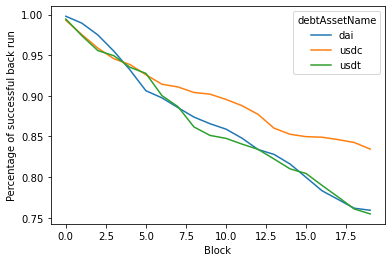

In [85]:
ratio_df = pd.concat(ratio_list,axis=1).T

ax = ratio_df[['dai','usdc', 'usdt']].plot()
ax.set_xlabel("Block")
ax.set_ylabel("Percentage of successful back run")
ax.get_figure().savefig('BackRunningRatio.pdf', format='pdf')

<AxesSubplot:>

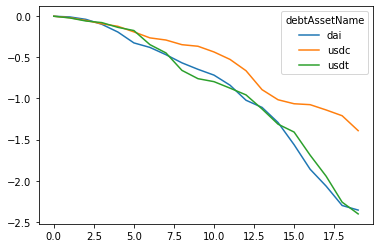

In [84]:
distance_df = pd.concat(block_distance_list,axis=1).T
distance_df.index = [i for i in range(distance_df.shape[0])]
distance_df.plot()

In [ ]:
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup as soup
import pandas as pd

url = 'https://etherscan.io/token/generic-tokentxns2?m=normal&contractAddress=0xd6a55c63865affd67e2fb9f284f87b7a9e5ff3bd&a=0xd071f6e384cf271282fc37eb40456332307bb8af'
req = Request(url, headers={'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'})   # I got this line from another post since "uClient = uReq(URL)" and "page_html = uClient.read()" would not work (I beleive that etherscan is attemption to block webscraping or something?)
response = urlopen(req, timeout=20).read()
response_close = urlopen(req, timeout=20).close()
page_soup = soup(response, "html.parser")
Transfers_info_table_1 = page_soup.find("table", {"class": "table table-md-text-normal table-hover mb-4"})
df=pd.read_html(str(Transfers_info_table_1))[0]
df.to_csv("TransferTable.csv",index=False)

In [235]:
import requests        #导入requests包
from bs4 import BeautifulSoup
import re
target_txs = pd.read_csv('data/mempool/chainlink_mempool.csv')['txHash']
data_dict = {}
for target_tx in tqdm.tqdm(target_txs):
    url = f'https://etherscan.io/tx/{target_tx}'
    strhtml = requests.get(url, headers={'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'}) 
    resp = BeautifulSoup(strhtml.text, "html.parser")
    confirmed_info = resp.find("span", attrs={'class':"text-secondary ml-2 d-none d-sm-inline-block"})
    if confirmed_info is not None:
        data_dict[target_tx] = confirmed_info.text.split('within')[-1]
data_dict

  0%|          | 64/24137 [00:26<2:48:35,  2.38it/s]


KeyboardInterrupt: 

In [230]:
confirmed_info.text

' |  Confirmed within 30 secs'

In [208]:
resp


<!DOCTYPE html>

<html lang="en">
<head><title>
	Ethereum Transaction Hash (Txhash) Details | Etherscan
</title><meta charset="utf-8"/><meta content="width=device-width, initial-scale=1, shrink-to-fit=no" name="viewport"/><meta content="etherscan.io" name="author"/><meta content="Ethereum (ETH) detailed transaction info for txhash 0x310fd97b6328ded404e8591c2162a0d9ff4931802d8313e59731258333d4e719. The transaction status, block confirmation, gas fee, Ether (ETH), and token transfer are shown." name="Description"/><meta content="ethereum, explorer, ether, search, blockchain, crypto, currency" name="keywords"/><meta content="telephone=no" name="format-detection"/>
<meta content="Ethereum Transaction Hash (Txhash) Details | Etherscan" property="og:title"/> <meta content="Ethereum (ETH) detailed transaction info for txhash 0x310fd97b6328ded404e8591c2162a0d9ff4931802d8313e59731258333d4e719. The transaction status, block confirmation, gas fee, Ether (ETH), and token transfer are shown." prop

In [204]:
resp.find("fal fa-stopwatch ml-1", attrs={'class':"ulist"})